In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
 
customers = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/customers.csv')
orders = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/orders.csv')
sellers = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/sellers.csv')
products = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/products.csv')
payments = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/payments.csv')
order_items = pd.read_csv('C:/Users/SAIKAT PRADHAN/Documents/Ecommerce Sales Dataset/order_items.csv')





#  BASIC  QUERIES:-

# 1.List all unique cities where customers are located.

In [6]:
unique_cities = customers['customer_city'].unique()

df = pd.DataFrame(unique_cities,columns = ['Cities'])
df.head()

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%d-%m-%Y %H:%M')

order_count_2017 = orders[orders['order_purchase_timestamp'].dt.year == 2017]['order_id'].count()

print("Total orders in 2017:", order_count_2017)

Total orders in 2017: 45101


# 3. Find the total sales per category.

In [28]:
merged_data = order_items.merge(products, on='product_id', how='inner') \
                         .merge(payments, on='order_id', how='inner')

sales_per_category = merged_data.groupby(merged_data['product category'].str.upper())['payment_value'].sum().round(2).reset_index()

sales_per_category.columns = ['Category', 'Sales']

df = pd.DataFrame(sales_per_category)
df.head()

,Category,Sales
0,AGRO INDUSTRIA E COMERCIO,118730.61
1,ART,30992.93
2,ARTS AND CRAFTS,2326.17
3,AUDIO,60324.62
4,AUTOMOTIVE,852294.33


# 4. Calculate the percentage of orders that were paid in installments.

In [22]:
installment_count = payments[payments['payment_installments'] >= 1].shape[0]

total_count = payments.shape[0]

percentage = (installment_count / total_count) * 100

print(f"Percentage of payments with installments: {percentage:.2f}%")

Percentage of payments with installments: 100.00%


# 5. Count the number of customers from each state. 

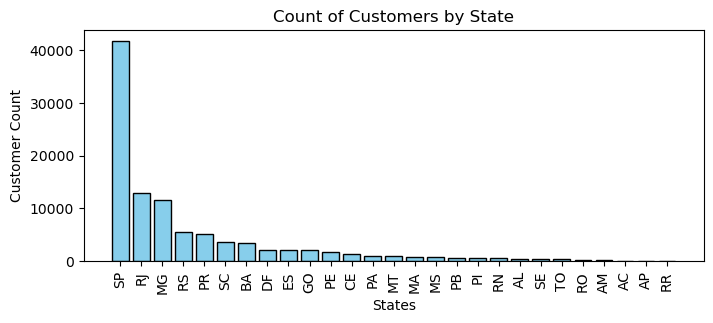

In [47]:
statewise_customers = customers.groupby('customer_state')['customer_id'].count().reset_index()

df = statewise_customers.rename(columns={"customer_state": "state", "customer_id": "customer_count"})

df = df.sort_values(by="customer_count", ascending=False)

plt.figure(figsize=(8, 3))
plt.bar(df["state"], df["customer_count"],color = 'skyblue',edgecolor = 'black',)
plt.xticks(rotation=90)
plt.xlabel("States")
plt.ylabel("Customer Count")
plt.title("Count of Customers by State")
plt.show()

# INTERMEDIATE QUERIES:-

# 1. Calculate the number of orders per month in 2018.

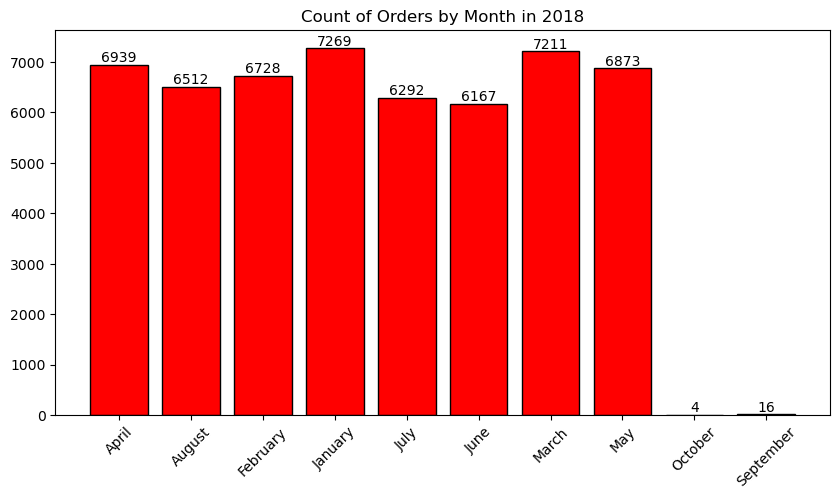

In [50]:
# Convert to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%d-%m-%Y %H:%M')

# Filter for 2018 orders
data_2018 = orders[orders['order_purchase_timestamp'].dt.year == 2018]

# Aggregate order counts per month
order_counts = data_2018.groupby(data_2018['order_purchase_timestamp'].dt.strftime('%B'))['order_id'].count()

# Ensure months are in chronological order
order_counts = order_counts.loc[pd.Categorical(order_counts.index, categories=[
    "January", "February", "March", "April", "May", "June", "July",
    "August", "September", "October", "November", "December"
], ordered=True)]

# Plot
plt.figure(figsize=(10, 5))
ax = plt.bar(order_counts.index, order_counts.values, color="red",edgecolor = 'black')
plt.xticks(rotation=45)
plt.title("Count of Orders by Month in 2018")

# Add labels
for bar in ax:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [17]:
# Convert timestamp column to datetime (if needed)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Count number of items per order
count_per_order = order_items.groupby("order_id").size().reset_index(name="Avg_products/Order")

# Merge with orders to get customer_id
count_per_order = count_per_order.merge(orders[['order_id', 'customer_id']], on="order_id")

# Merge with customers to get city
result = count_per_order.merge(customers[['customer_id', 'customer_city']], on="customer_id")

# Compute average orders per city
average_orders = result.groupby("customer_city")['Avg_products/Order'].mean().round(2).reset_index()

# Sort by descending order
average_orders = average_orders.sort_values(by="Avg_products/Order", ascending=False)

df = pd.DataFrame(average_orders)
df.head()

,customer_city,Avg_products/Order
2619,padre carvalho,7.0
907,celso ramos,6.5
756,candido godoi,6.0
1154,datas,6.0
2264,matias olimpio,5.0


# 3. Calculate the percentage of total revenue contributed by each product category.

In [20]:
# Merge datasets
df = order_items.merge(products[['product_id', 'product category']], on="product_id")
df = df.merge(payments[['order_id', 'payment_value']], on="order_id")

# Convert product categories to uppercase
df['product category'] = df['product category'].str.upper()

# Calculate total payment value
total_sales = df['payment_value'].sum()

# Compute sales percentage for each category
sales_percentage = df.groupby("product category")['payment_value'].sum().div(total_sales).mul(100).round(2)

# Convert result to DataFrame and sort by descending order
sales_percentage_df = sales_percentage.reset_index().sort_values(by="payment_value", ascending=False)

df = pd.DataFrame(sales_percentage_df)
df.head()

,product category,payment_value
7,BED TABLE BATH,8.43
44,HEALTH BEAUTY,8.16
15,COMPUTER ACCESSORIES,7.81
72,WATCHES PRESENT,7.04
38,FURNITURE DECORATION,7.04


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [41]:
# Merge datasets on product_id
df = order_items.merge(products, on="product_id")

# Count purchase frequency for each product
purchase_counts = df.groupby("product_id")["product_id"].size().rename("purchase_count")

# Merge purchase counts with product price from order_items
correlation_data = order_items[['product_id', 'price']].drop_duplicates().merge(purchase_counts, on="product_id", how="left").fillna(0)

# Compute correlation
corr_value = np.corrcoef(correlation_data["price"], correlation_data["purchase_count"])[0, 1]

print(f"The correlation between product price and purchase frequency is: {corr_value:.2f}")

The correlation between product price and purchase frequency is: -0.02


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

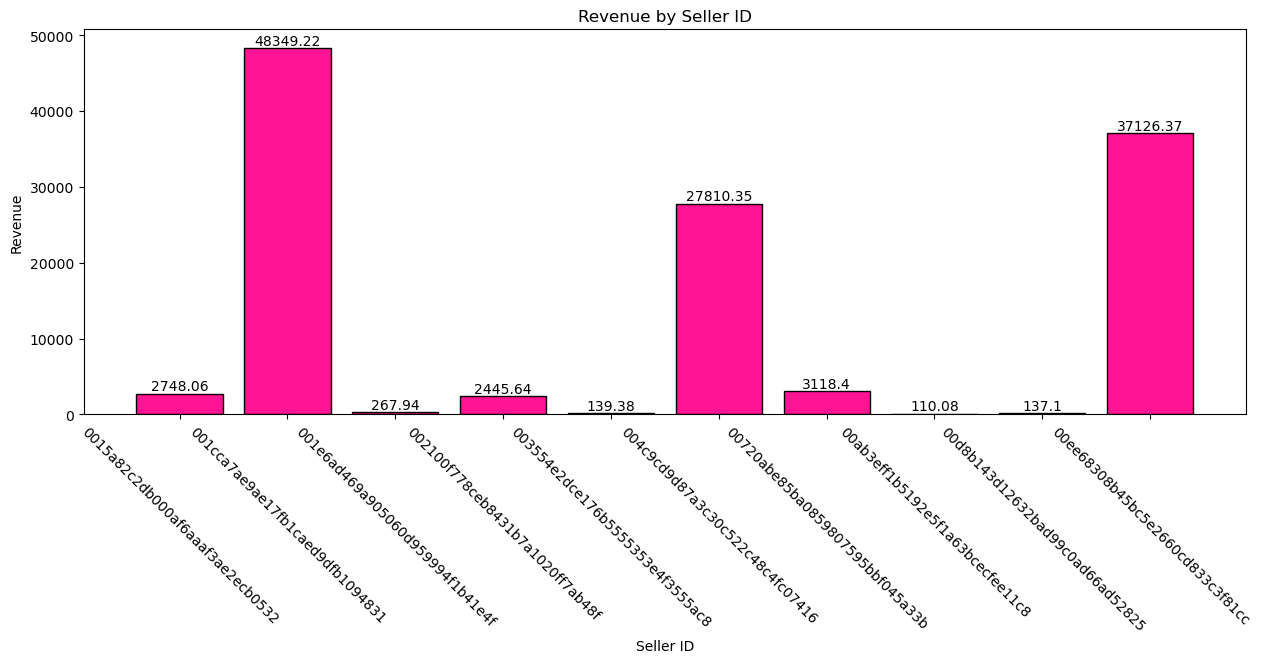

In [65]:
# Perform the join and aggregation
revenue_df = order_items.merge(payments, on='order_id') \
                        .groupby('seller_id', as_index=False) \
                        .agg({'payment_value': 'sum'}) \
                        .rename(columns={'payment_value': 'revenue'})

# Compute the dense rank
revenue_df['rn'] = revenue_df['revenue'].rank(method='dense', ascending=False).astype(int)

df = pd.DataFrame(revenue_df, columns = ["seller_id", "revenue", "rank"])
df = df.head(10)

# Plot bar chart
plt.figure(figsize=(15, 5))
plt.bar(df["seller_id"], df["revenue"], color='deeppink',edgecolor = 'black')

# Annotate bars
ax = plt.gca()
for bar in ax.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=-45)
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.title("Revenue by Seller ID")
plt.show()